## Install PySpark

In [2]:
!pip install pyspark

## Import libraries

In [3]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number, desc
from pyspark.sql.window import Window

from pyspark.sql import functions as F
from pyspark.sql import SparkSession

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Create Spark Session

In [4]:
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [5]:
spark

## Load data

### Load Ball_by_ball data

In [6]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header", "true").load("data/Ball_By_Ball.csv")

In [7]:
ball_by_ball_df = ball_by_ball_df.filter(ball_by_ball_df.over_id != 383)

replacements = {
    "Kolkata Knight Riders": 1,
    "Royal Challengers Bangalore": 2,
    "Chennai Super Kings": 3,
    "Kings XI Punjab": 4,
    "Rajasthan Royals": 5,
    "Delhi Daredevils": 6,
    "Mumbai Indians": 7,
    "Deccan Chargers": 8,
    "Kochi Tuskers Kerala": 9,
    "Pune Warriors": 10,
    "Sunrisers Hyderabad": 11,
    "Rising Pune Supergiants": 12,
    "Gujarat Lions": 13
}

for team_name, team_id in replacements.items():
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_batting",
        F.when(ball_by_ball_df["team_batting"] == team_name, team_id).otherwise(ball_by_ball_df["team_batting"])
    )
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_bowling",
        F.when(ball_by_ball_df["team_bowling"] == team_name, team_id).otherwise(ball_by_ball_df["team_bowling"])
    )

out_types = ['Keeper Catch', 'bowled', 'caught', 'stumped', 'lbw',
             'run out', 'caught and bowled', 'hit wicket', 'obstructing the field']

ball_by_ball_df = ball_by_ball_df.withColumn(
    "bowler_wicket",
    F.when(F.col("out_type").isin(out_types), 1).otherwise(0)
)


columns_to_drop = [
    'caught', 'bowled', 'run_out', 'lbw', 'retired_hurt', 'matchdatesk','match_date',
    'stumped', 'caught_and_bowled', 'hit_wicket', 'obstructingfeild', 'keeper_catch'
]

ball_by_ball_df = ball_by_ball_df.drop(*columns_to_drop)

pandas_df = ball_by_ball_df.toPandas()


### Load Match data

In [12]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header", "true").load("data/Match.csv")

match_df = match_df.withColumn(
    'win_type',
    F.when(F.col('win_type') == 'run', 'runs') 
     .when((F.col('win_type') == 'NA') | (F.col('win_type').isNull()), 'No Result') 
     .when(F.lower(F.col('win_type')) == 'no result', 'No Result')  
     .otherwise(F.col('win_type'))
)

match_df = match_df.withColumn(
    'toss_name',
    F.when(F.col('toss_name') == 'NA', None)  
     .otherwise(F.lower(F.col('toss_name')))
)  # Missing parenthesis was added here

pandas_match_df = match_df.toPandas()

### Load Player Data

In [13]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("data/Player.csv")
pd_player_df = player_df.toPandas()

### Load Player Match Data

In [14]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("data/Player_match.csv")


In [15]:
batting_hand_replacements = {
    '�Right-hand bat': 'Right-hand bat',
    'Right-handed': 'Right-hand bat',
    '�Left-hand bat': 'Left-hand bat'
}

bowling_skill_replacements = {
    'N/A': None,
    'NULL': None,
    'Right-arm medium fast': 'Right-arm medium-fast',
    '�Right-arm fast-medium': 'Right-arm fast-medium',
    '�Left-arm fast': 'Left-arm fast',
    '�Right-arm medium-fast': 'Right-arm medium-fast',
    '�Right-arm offbreak': 'Right-arm offbreak',
    '�Legbreak': 'Legbreak'
}

player_match_df = player_match_df.replace(batting_hand_replacements, subset=['batting_hand'])

player_match_df = player_match_df.replace(bowling_skill_replacements, subset=['bowling_skill'])

### Load Team data

In [16]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("data/Team.csv")


In [17]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

# 1. Team Performance Insights


## 1.1. Total Runs Scored by Each Team Across All Seasons

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\3197610550.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_name', y='total_runs', data=team_runs_pd, palette='Blues_d')


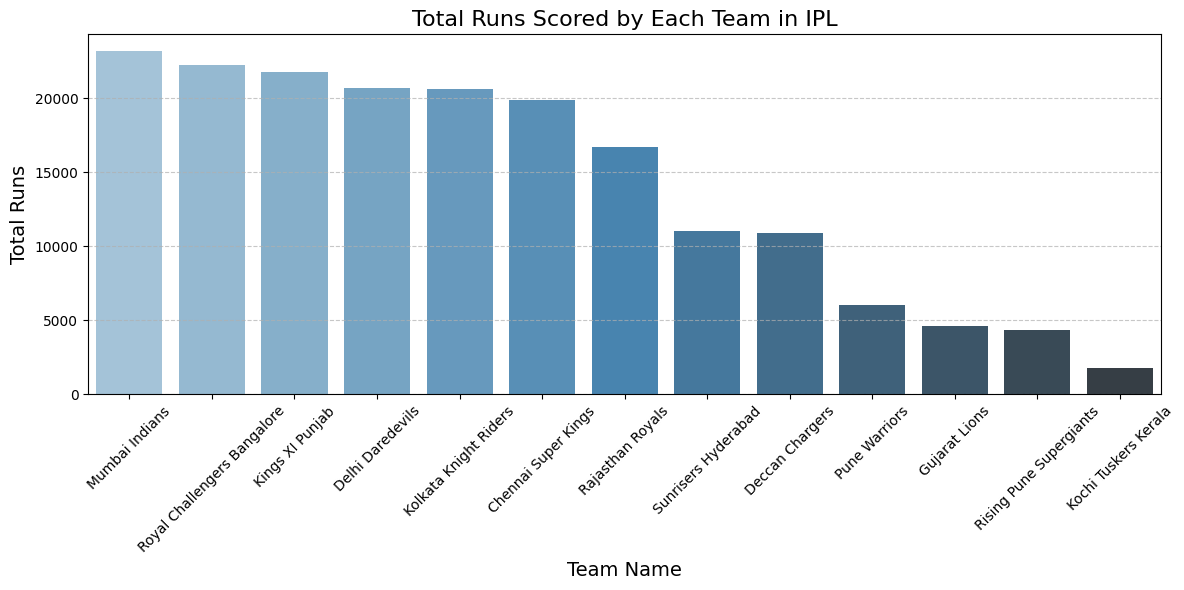

In [18]:
team_runs_df = ball_by_ball_df.groupBy('battingteam_sk').agg(
    F.sum('runs_scored').alias('total_runs')
)

team_runs_with_names = team_runs_df.join(
    team_df,
    team_runs_df.battingteam_sk == team_df.team_sk,'inner').select(team_df.team_name,team_runs_df.total_runs).orderBy(F.desc('total_runs'))

team_runs_pd = team_runs_with_names.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='team_name', y='total_runs', data=team_runs_pd, palette='Blues_d')

plt.title('Total Runs Scored by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 1.2. Total Wickets Taken by Each Team Across All Seasons

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\2344986035.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_name', y='total_wickets', data=team_wickets_pd, palette='muted')


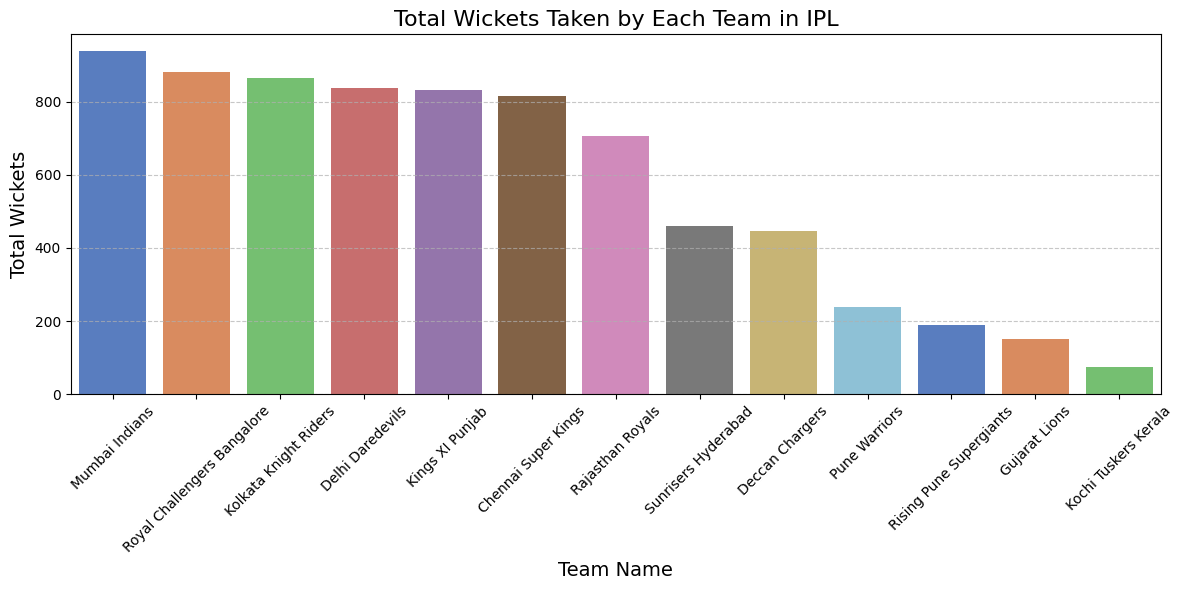

In [19]:
team_wickets_df = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == 1) \
    .groupBy('bowlingteam_sk').agg(
        F.count('bowler_wicket').alias('total_wickets')
    )

team_wickets_with_names = team_wickets_df.join(
    team_df,
    team_wickets_df.bowlingteam_sk == team_df.team_sk,
    'inner'
).select(
    team_df.team_name,
    team_wickets_df.total_wickets
).orderBy(F.desc('total_wickets'))

team_wickets_pd = team_wickets_with_names.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='team_name', y='total_wickets', data=team_wickets_pd, palette='muted')

plt.title('Total Wickets Taken by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 1.3. Most Successful Teams per Season

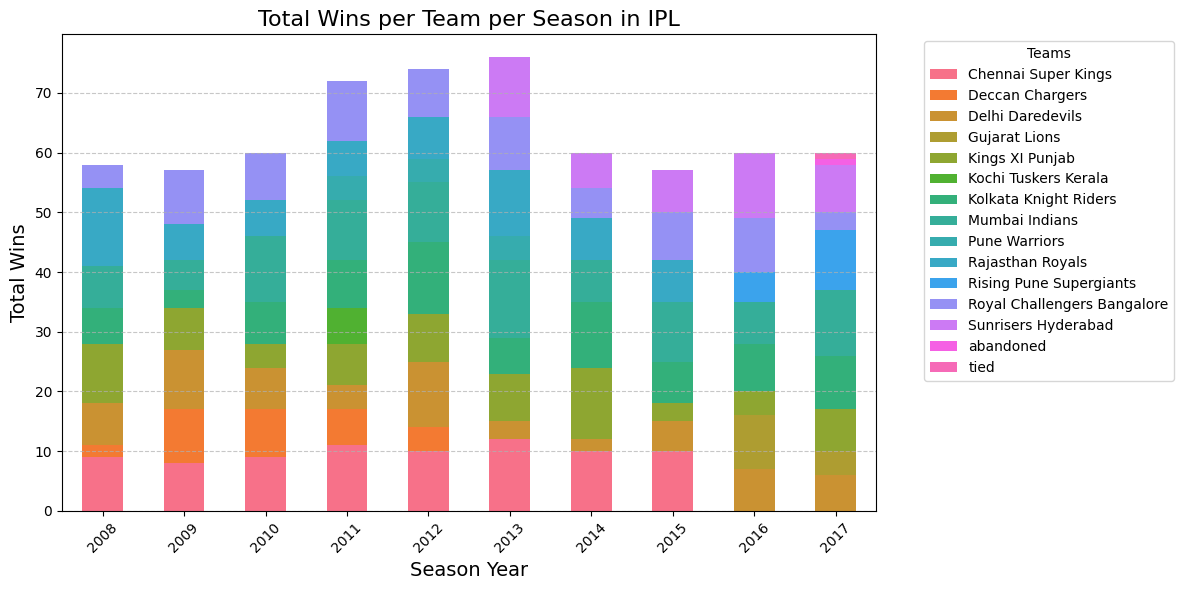

In [20]:
team_wins_per_season = match_df.groupBy('match_winner', 'season_year').agg(F.count('match_id').alias('total_wins')).orderBy(F.desc('total_wins'))

team_wins_per_season_pd = team_wins_per_season.toPandas()

team_wins_per_season_pd.replace('NULL', None, inplace=True)
team_wins_per_season_pd = team_wins_per_season_pd.dropna()

pivot_df = team_wins_per_season_pd.pivot(index='season_year', columns='match_winner', values='total_wins').fillna(0)

num_teams = len(pivot_df.columns)

colors = sns.color_palette("husl", num_teams)
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Total Wins per Team per Season in IPL', fontsize=16)
plt.xlabel('Season Year', fontsize=14)
plt.ylabel('Total Wins', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 1.4. Average Runs Scored by Teams

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\14278209.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=average_runs_in_powerplay_pd,


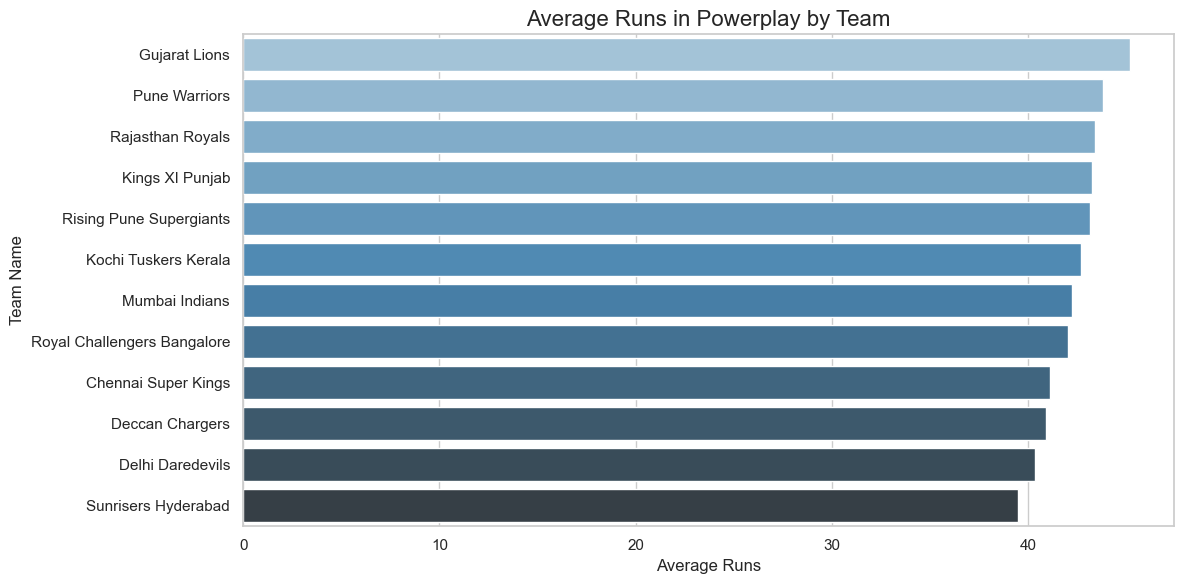

In [21]:
average_runs_in_powerplay = spark.sql('''WITH cte AS (
    SELECT
        Team_Batting,
        SUM(Runs_scored) AS runs,
        COUNT(DISTINCT match_id) AS match_count
    FROM
        ball_by_ball
    WHERE
        over_id < 7
    GROUP BY
        Team_Batting
)
SELECT
    b.Team_name,
    ROUND((SUM(runs) / MAX(match_count)), 2) AS average_runs
FROM
    cte a
    INNER JOIN team b
    ON a.Team_Batting = b.team_sk
GROUP BY
    b.Team_name
ORDER BY
    average_runs DESC;
''')

average_runs_in_powerplay_pd = average_runs_in_powerplay.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=average_runs_in_powerplay_pd, 
                       x='average_runs', 
                       y='Team_name', 
                       palette='Blues_d')

plt.title('Average Runs in Powerplay by Team', fontsize=16)
plt.xlabel('Average Runs', fontsize=12)
plt.ylabel('Team Name', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# 2. Player Performance Insights

## 2.1. Top Run Scorers

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\1167623309.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')


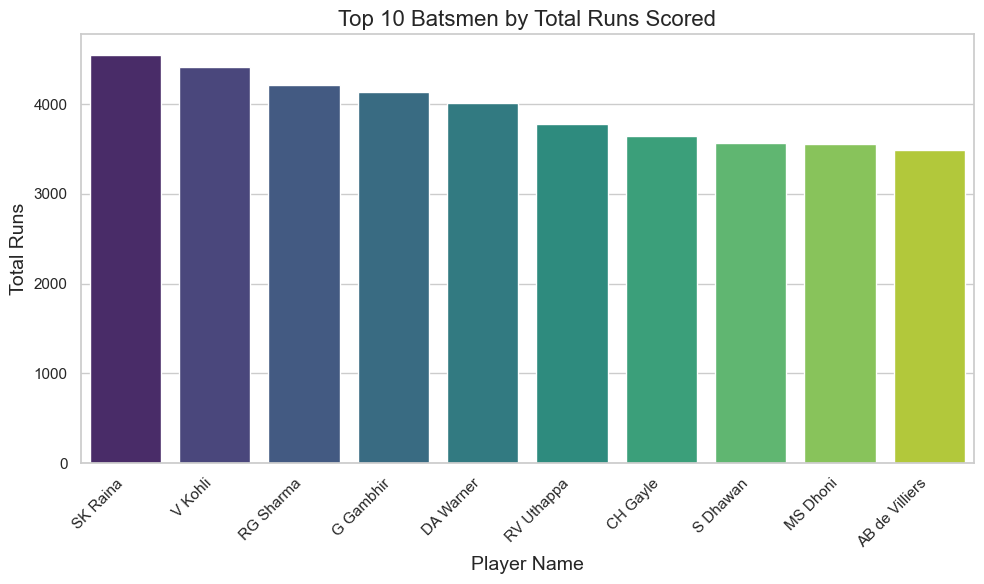

In [22]:
top_batsmen = ball_by_ball_df.join(player_df, ball_by_ball_df["Striker"] == player_df["player_id"]) \
    .groupBy("player_name") \
    .agg(sum("Runs_Scored").alias("total_runs")) \
    .orderBy(desc("total_runs"))

top_batsmen_pd = top_batsmen.limit(10).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')

plt.xticks(rotation=45, ha='right')

plt.title('Top 10 Batsmen by Total Runs Scored', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)

plt.tight_layout()
plt.show()

## 2.2. Top Wicket-Takers

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\3296998961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')


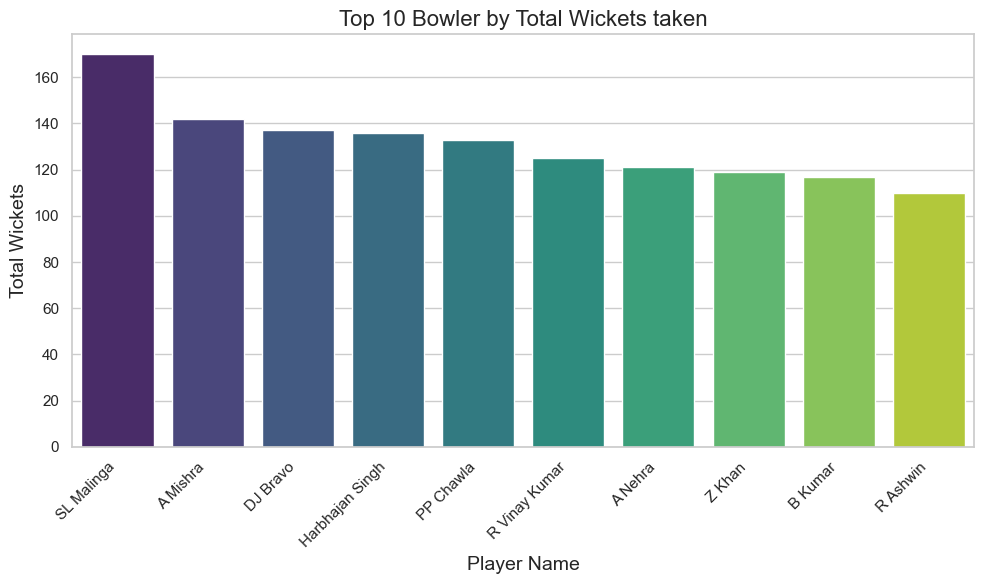

In [23]:
player_wickets = ball_by_ball_df.filter(
    ball_by_ball_df['out_type'] != 'Not Applicable'
).groupBy('bowler').agg(
    F.count('out_type').alias('total_wickets')
)

joined_df = player_wickets.join(player_df, player_wickets.bowler == player_df.player_id, how="inner")

top_bowlers_df = joined_df.select(player_df["player_name"], player_wickets["total_wickets"]) \
                           .orderBy(player_wickets["total_wickets"].desc()) \
                           .limit(10) \
                           .toPandas()

plt.figure(figsize=(10, 6))

sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')

plt.xticks(rotation=45, ha='right')

plt.title('Top 10 Bowler by Total Wickets taken', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)

plt.tight_layout()
plt.show()

## 2.3.  Consistency in Performance (Matches Played vs Runs/Wickets)

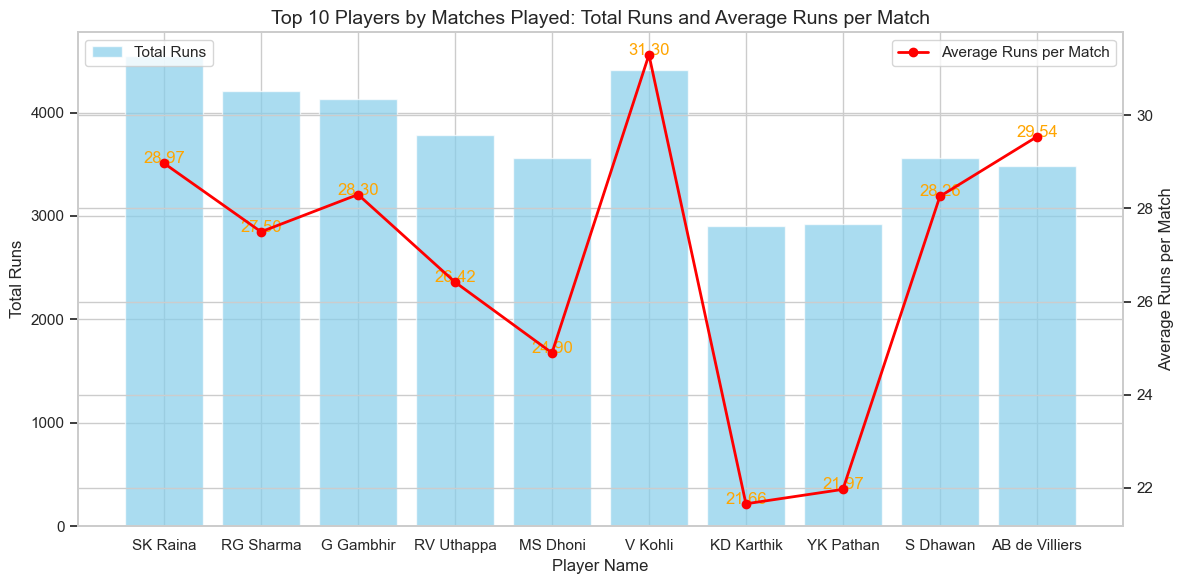

In [24]:
player_match_count = ball_by_ball_df.groupBy('striker').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.sum('runs_scored').alias('total_runs')
)

joined_df = player_match_count.join(player_df, player_match_count.striker == player_df.player_id, how='inner')

result_df = joined_df.select(player_df["player_name"], player_match_count["matches_played"], player_match_count["total_runs"]) \
                      .withColumn('average_runs_per_match',
                                  F.format_number(
                                      F.when(player_match_count["matches_played"] > 0,
                                              player_match_count["total_runs"] / player_match_count["matches_played"])
                                      .otherwise(0), 2)) \
                      .orderBy(player_match_count["total_runs"].desc())

pandas_df = result_df.toPandas()

top_10_players = pandas_df.nlargest(10, 'matches_played')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top_10_players['player_name'], top_10_players['total_runs'],
        color='skyblue', label='Total Runs', alpha=0.7)
ax1.set_xlabel('Player Name', fontsize=12)
ax1.set_ylabel('Total Runs', fontsize=12)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(top_10_players['player_name'], top_10_players['average_runs_per_match'].astype(float),
         color='red', marker='o', label='Average Runs per Match', linewidth=2, zorder=5)
ax2.set_ylabel('Average Runs per Match', fontsize=12)
ax2.tick_params(axis='y')

for index, row in top_10_players.iterrows():
    ax2.text(row['player_name'], float(row['average_runs_per_match']),
             f"{float(row['average_runs_per_match']):.2f}", horizontalalignment='center', color='orange')

plt.title('Top 10 Players by Matches Played: Total Runs and Average Runs per Match', fontsize=14)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

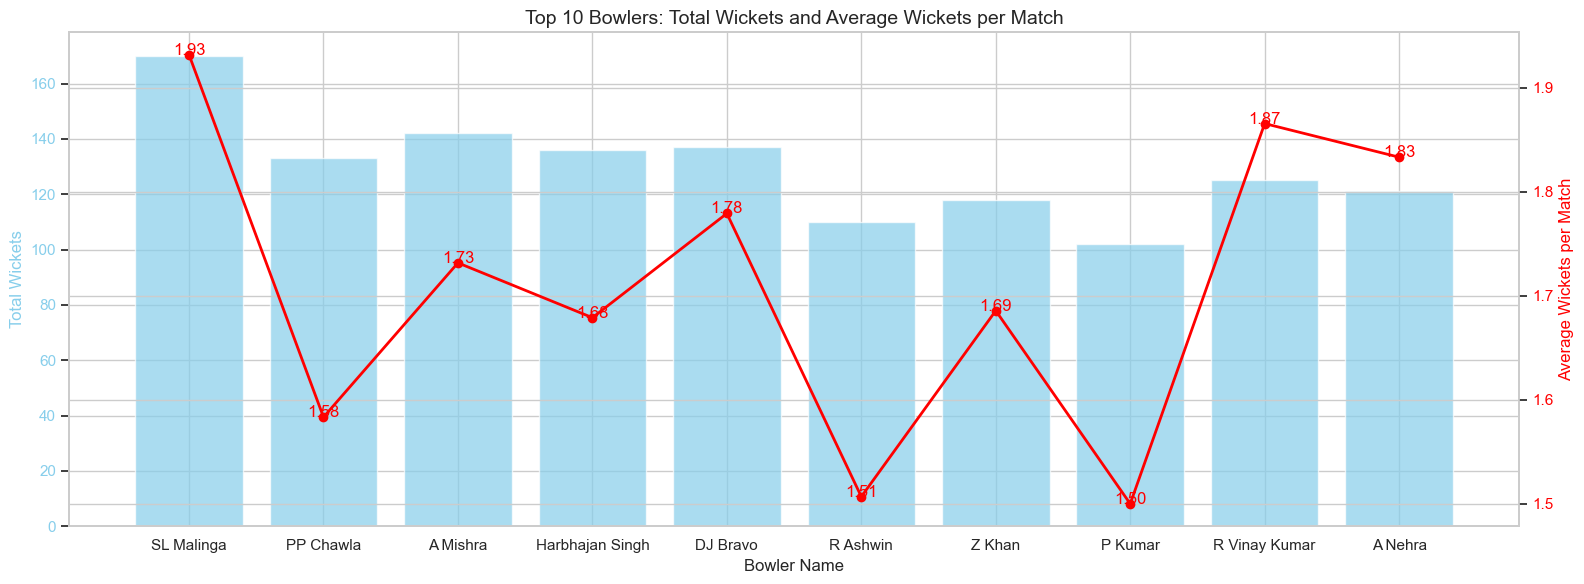

In [25]:
bowler_match_count = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.count('bowler_wicket').alias('total_wickets')
)

joined_bowler_df = bowler_match_count.join(player_df, bowler_match_count.bowler == player_df.player_id, how='inner')


result_bowler_df = joined_bowler_df.select(
    player_df["player_name"],
    bowler_match_count["matches_played"],
    bowler_match_count["total_wickets"]
).withColumn(
    'average_wickets_per_match',
    F.when(bowler_match_count["matches_played"] > 0,
           bowler_match_count["total_wickets"] / bowler_match_count["matches_played"])
    .otherwise(0)
).orderBy(bowler_match_count["total_wickets"].desc())

# Show the results
# result_bowler_df.show()

pandas_bowler_df = result_bowler_df.toPandas()

# Filter for top 10 bowlers by matches played
top_10_bowlers = pandas_bowler_df.nlargest(10, 'matches_played')

# Set the figure size (increase the width)
plt.figure(figsize=(16, 6))  # Increase the width to 16
fig, ax1 = plt.subplots(figsize=(16, 6))  # Increase the width to 16

# Bar chart for total wickets
color = 'skyblue'
ax1.set_xlabel('Bowler Name', fontsize=12)
ax1.set_ylabel('Total Wickets', fontsize=12, color=color)
ax1.bar(top_10_bowlers['player_name'], top_10_bowlers['total_wickets'], color=color, alpha=0.7, label='Total Wickets')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for average wickets per match
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Average Wickets per Match', fontsize=12, color=color)
ax2.plot(top_10_bowlers['player_name'], top_10_bowlers['average_wickets_per_match'], color=color, marker='o', linewidth=2, label='Average Wickets per Match')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for average wickets per match
for index, row in top_10_bowlers.iterrows():
    ax2.text(row['player_name'], row['average_wickets_per_match'],
             f"{row['average_wickets_per_match']:.2f}", horizontalalignment='center', color=color)

# Set the title
plt.title('Top 10 Bowlers: Total Wickets and Average Wickets per Match', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# 3. Match and Toss Insights

## 3.1. Toss Decision Impact on Match Outcome

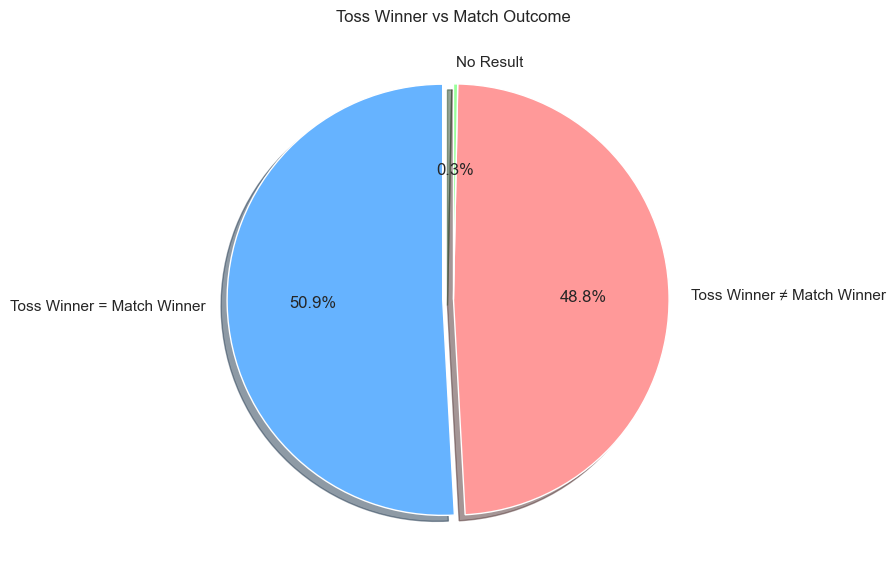

In [26]:
toss_match_wins = match_df.filter(match_df['toss_winner'] == match_df['match_winner']).count() / match_df.count() * 100

toss_match_loss = match_df.filter((match_df['toss_winner'] != match_df['match_winner']) &
                                  (match_df['match_winner'] != 'tied') &
                                  (match_df['match_winner'] != 'abandoned')).count() / match_df.count() * 100

toss_match_noresult = match_df.filter((match_df['match_winner'] == 'tied') |
                                      (match_df['match_winner'] == 'abandoned')).count() / match_df.count() * 100

labels = ['Toss Winner = Match Winner', 'Toss Winner ≠ Match Winner', 'No Result']
sizes = [toss_match_wins, toss_match_loss, toss_match_noresult]
colors = ['#66b3ff', '#ff9999', '#99ff99']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0), shadow=True)
plt.title('Toss Winner vs Match Outcome')
plt.show()

## 3.2. Match Outcomes (Win by Runs or Wickets)

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\3159942914.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_types, y=win_counts, palette='viridis')


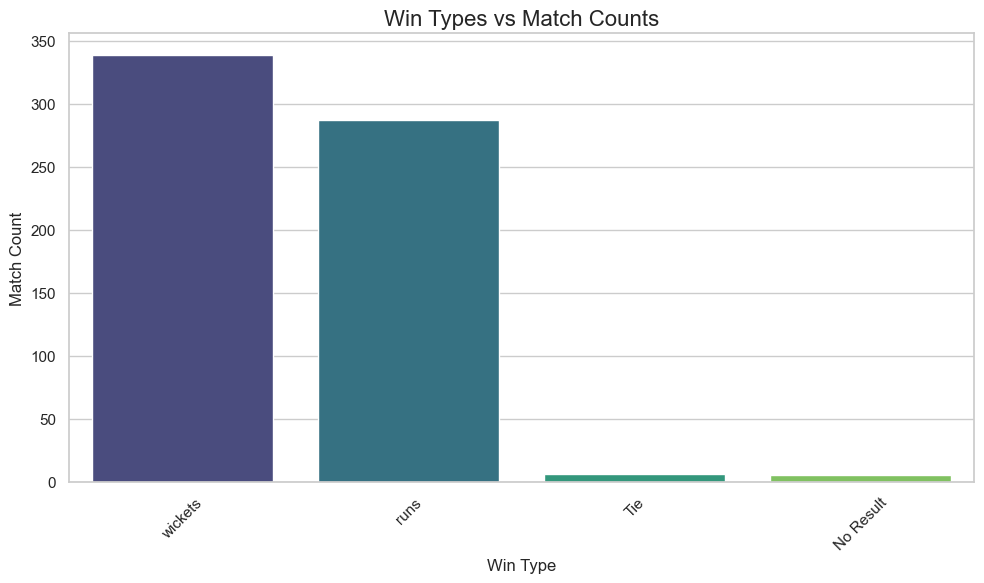

In [27]:
win_type_count = match_df.groupBy('win_type').agg(F.count('match_id').alias('win_count')).orderBy(F.desc('win_count'))

win_type_count_pd = win_type_count.toPandas()

win_types = win_type_count_pd['win_type']
win_counts = win_type_count_pd['win_count']

plt.figure(figsize=(10, 6))
sns.barplot(x=win_types, y=win_counts, palette='viridis')

plt.title('Win Types vs Match Counts', fontsize=16)
plt.xlabel('Win Type', fontsize=12)
plt.ylabel('Match Count', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3.3. Team Performance After Winning Toss

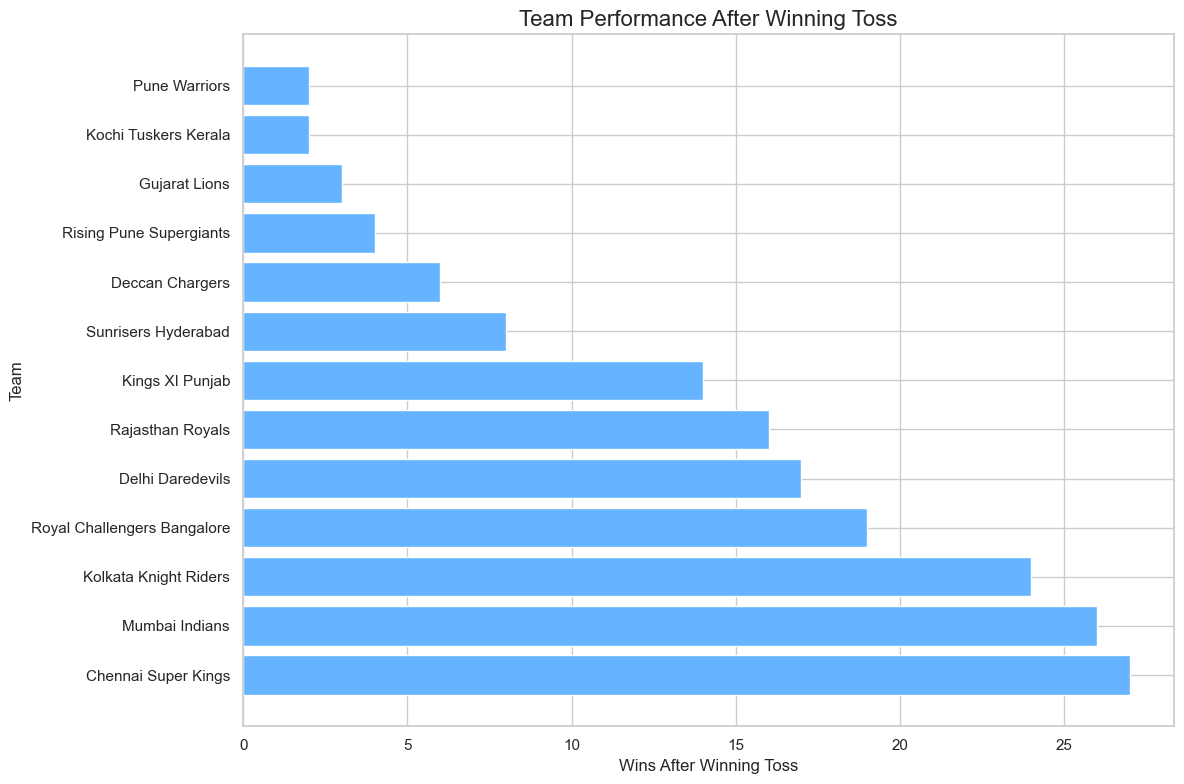

In [28]:
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")
team_toss_win_pd = team_toss_win_performance.toPandas()

plt.figure(figsize=(12, 8))

plt.barh(team_toss_win_pd['team1'], team_toss_win_pd['wins_after_toss'], color='#66b3ff')

plt.title('Team Performance After Winning Toss', fontsize=16)
plt.xlabel('Wins After Winning Toss', fontsize=12)
plt.ylabel('Team', fontsize=12)

plt.tight_layout()

plt.show()

# 4. Season Insights

## 4.1. Season-wise Total Runs 

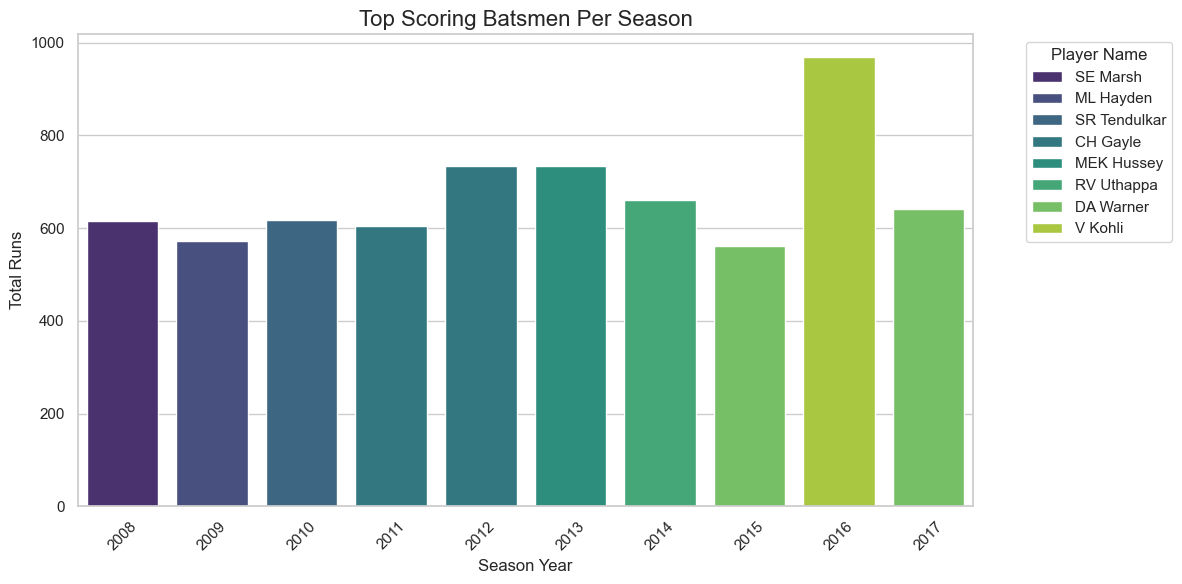

In [29]:
top_scoring_batsmen_per_season = spark.sql("""
WITH PlayerRunsPerSeason AS (
    SELECT
        p.player_name,
        m.season_year,
        SUM(b.runs_scored) AS total_runs,
        ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.runs_scored) DESC) AS rank
    FROM ball_by_ball b
    JOIN match m ON b.match_id = m.match_id
    JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
    JOIN player p ON p.player_id = pm.player_id
    GROUP BY p.player_name, m.season_year
)
SELECT
    player_name,
    season_year,
    total_runs
FROM PlayerRunsPerSeason
WHERE rank = 1
ORDER BY season_year;
""")

top_scoring_batsmen_pd = top_scoring_batsmen_per_season.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=top_scoring_batsmen_pd, 
                       x='season_year', 
                       y='total_runs', 
                       hue='player_name', 
                       palette='viridis')

plt.title('Top Scoring Batsmen Per Season', fontsize=16)
plt.xlabel('Season Year', fontsize=12)
plt.ylabel('Total Runs', fontsize=12)

plt.xticks(rotation=45)

plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 4.2. Season-wise Total Wickets

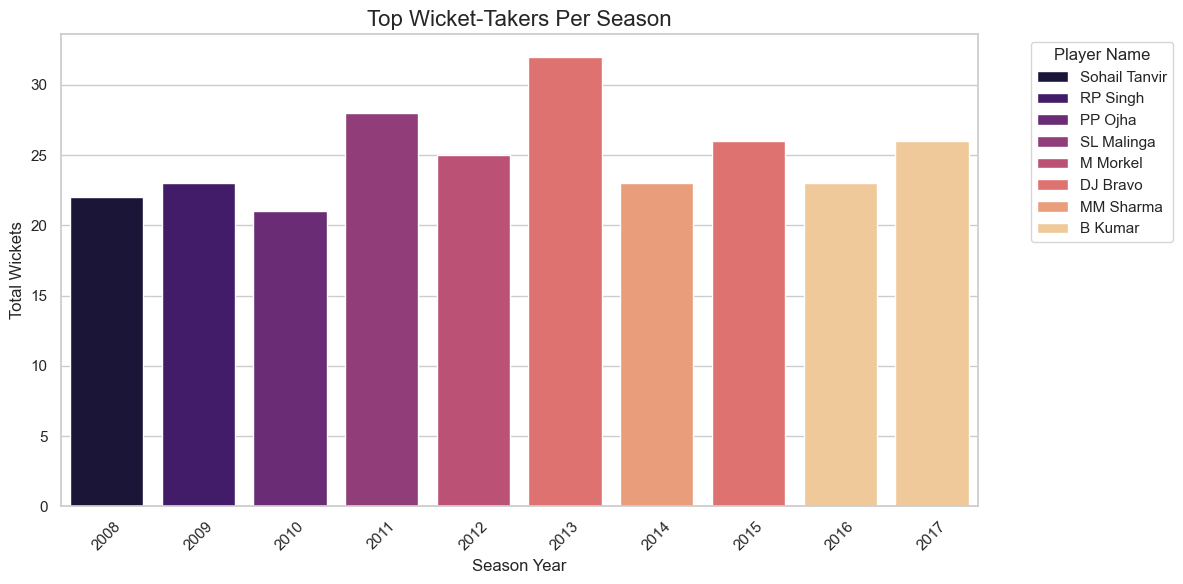

In [30]:
top_wicket_bowler_per_season = spark.sql("""
WITH PlayerWicketsPerSeason AS (
    SELECT
        p.player_name,
        m.season_year,
        SUM(b.bowler_wicket) AS total_wicket,
        ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.bowler_wicket) DESC) AS rank
    FROM ball_by_ball b
    JOIN match m ON b.match_id = m.match_id
    JOIN player_match pm ON m.match_id = pm.match_id AND b.bowler = pm.player_id
    JOIN player p ON p.player_id = pm.player_id
    WHERE b.bowler_wicket = 1 and out_type IN ('Keeper Catch', 'bowled', 'caught', 'stumped', 'lbw', 'caught and bowled', 'hit wicket', 'obstructing the field')
    GROUP BY p.player_name, m.season_year
)
SELECT
    player_name,
    season_year,
    total_wicket
FROM PlayerWicketsPerSeason
WHERE rank = 1
ORDER BY season_year;
""")

top_wicket_bowler_pd = top_wicket_bowler_per_season.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=top_wicket_bowler_pd, 
                       x='season_year', 
                       y='total_wicket', 
                       hue='player_name', 
                       palette='magma')

plt.title('Top Wicket-Takers Per Season', fontsize=16)
plt.xlabel('Season Year', fontsize=12)
plt.ylabel('Total Wickets', fontsize=12)

plt.xticks(rotation=45)

plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# 5. Venue and City Insights

## 5.1. Most Popular Venues for IPL Matches

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\452832458.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_matches, y=venues, palette='Blues')


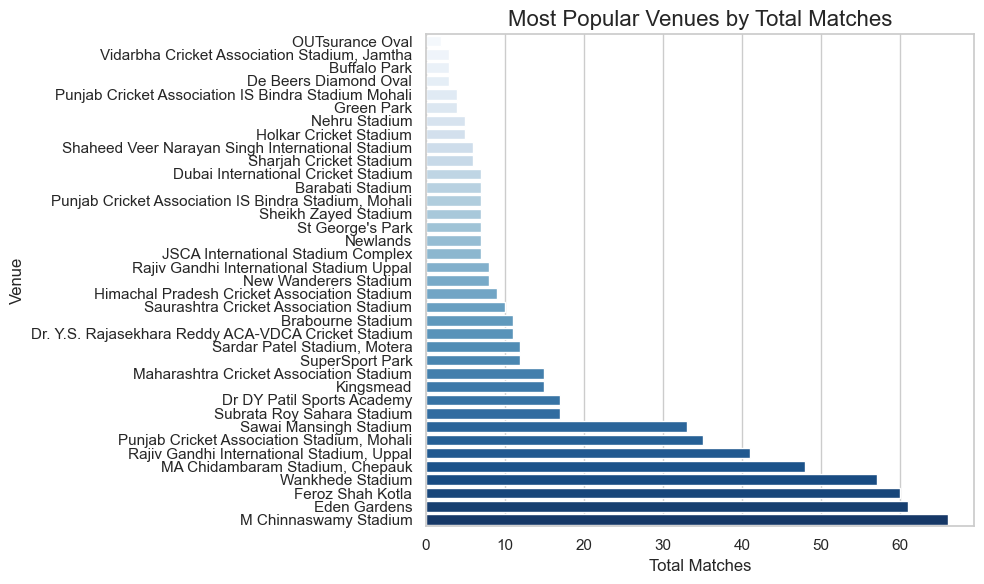

In [31]:
venue_count = match_df.groupBy('venue_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.asc('total_matches'))
venue_count = venue_count.filter(venue_count['venue_name'] != 'NULL')

venue_count_pd = venue_count.toPandas()

venues = venue_count_pd['venue_name']
total_matches = venue_count_pd['total_matches']

plt.figure(figsize=(10, 6))
sns.barplot(x=total_matches, y=venues, palette='Blues')

plt.title('Most Popular Venues by Total Matches', fontsize=16)
plt.xlabel('Total Matches', fontsize=12)
plt.ylabel('Venue', fontsize=12)

plt.tight_layout()
plt.show()

## 5.2. Most Popular Cities for IPL Matches

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\3422021535.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city_name', y='total_matches', data=city_count_pd, palette='Blues_d')


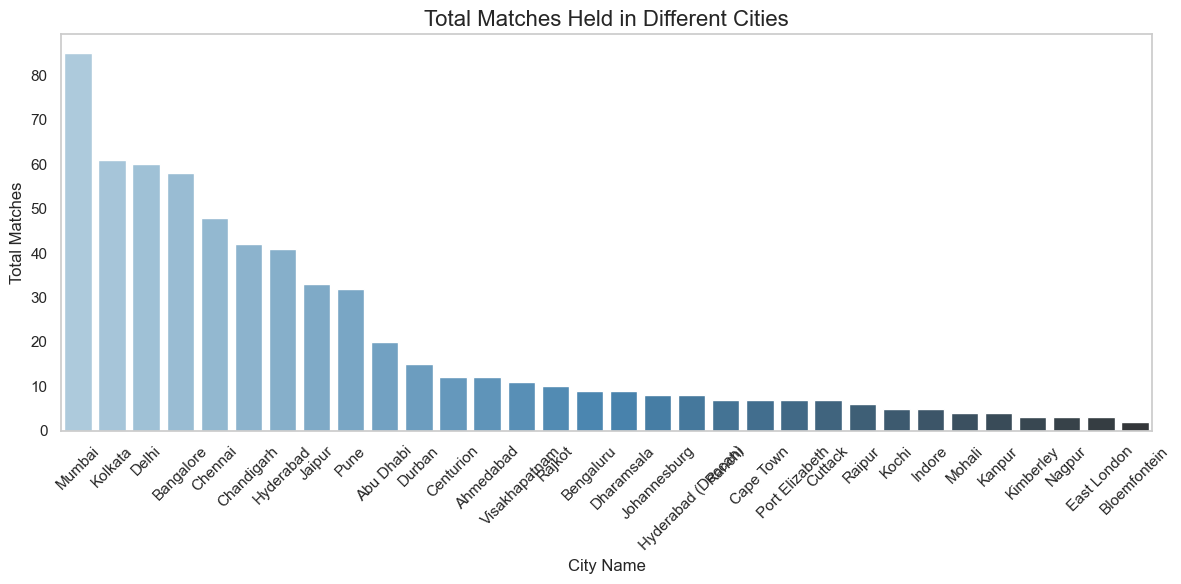

In [32]:
city_count = match_df.groupBy('city_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.desc('total_matches'))

city_count_pd = city_count.toPandas()

city_count_pd = city_count_pd.sort_values(by='total_matches', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='city_name', y='total_matches', data=city_count_pd, palette='Blues_d')

plt.xticks(rotation=45)
plt.title('Total Matches Held in Different Cities', fontsize=16)
plt.xlabel('City Name', fontsize=12)
plt.ylabel('Total Matches', fontsize=12)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## 5.3. Home Ground Advantage in Match

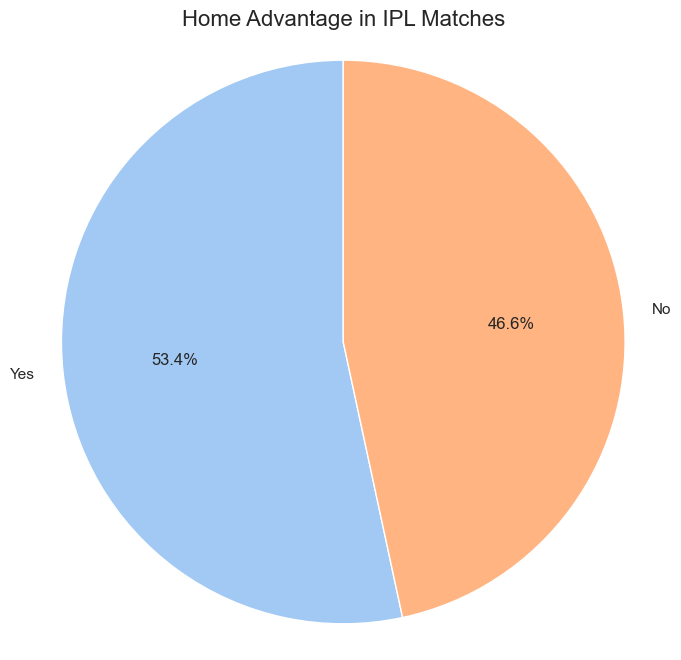

In [33]:
home_advantage = match_df.withColumn("is_home_win", match_df["match_winner"] == match_df["team1"]).groupBy("is_home_win").count()

home_advantage_pd = home_advantage.toPandas()

home_advantage_pd['is_home_win'] = home_advantage_pd['is_home_win'].map({True: 'Yes', False: 'No'})

plt.figure(figsize=(8, 8))
plt.pie(home_advantage_pd['count'], labels=home_advantage_pd['is_home_win'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))

plt.title('Home Advantage in IPL Matches', fontsize=16)
plt.axis('equal')

plt.show()


## 5.4. Average Runs Scored in Each Venue

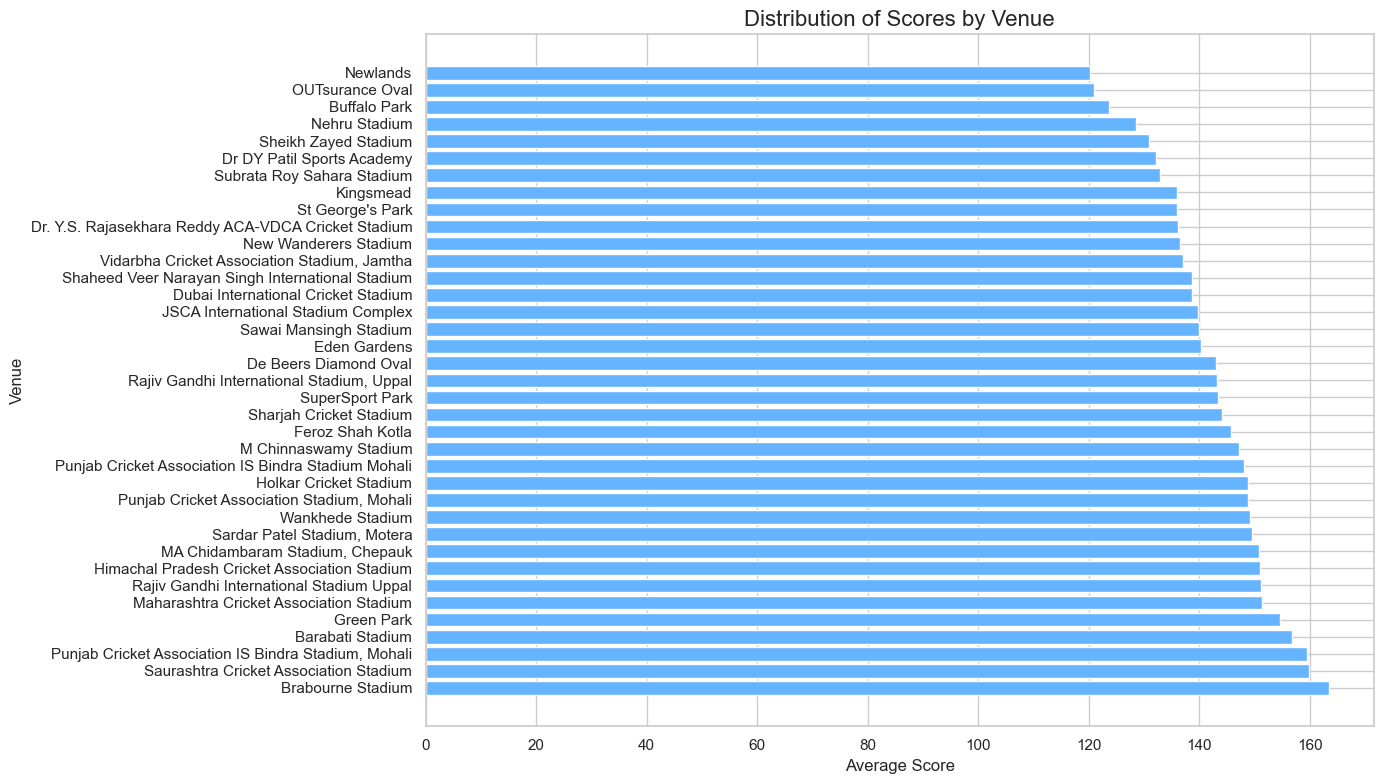

In [34]:
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs)/2 AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")

scores_by_venue_pd = scores_by_venue.toPandas()

plt.figure(figsize=(14, 8))

plt.barh(scores_by_venue_pd['venue_name'], scores_by_venue_pd['average_score'], color='#66b3ff')

plt.title('Distribution of Scores by Venue', fontsize=16)
plt.xlabel('Average Score', fontsize=12)
plt.ylabel('Venue', fontsize=12)

plt.tight_layout()
plt.show()


# 6. Fielding and Extras Insights

## 6.1. Top Players Involved in Run Outs

C:\Users\risha\AppData\Local\Temp\ipykernel_50348\3392881246.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=run_out_counts, y=player_names, palette='coolwarm')


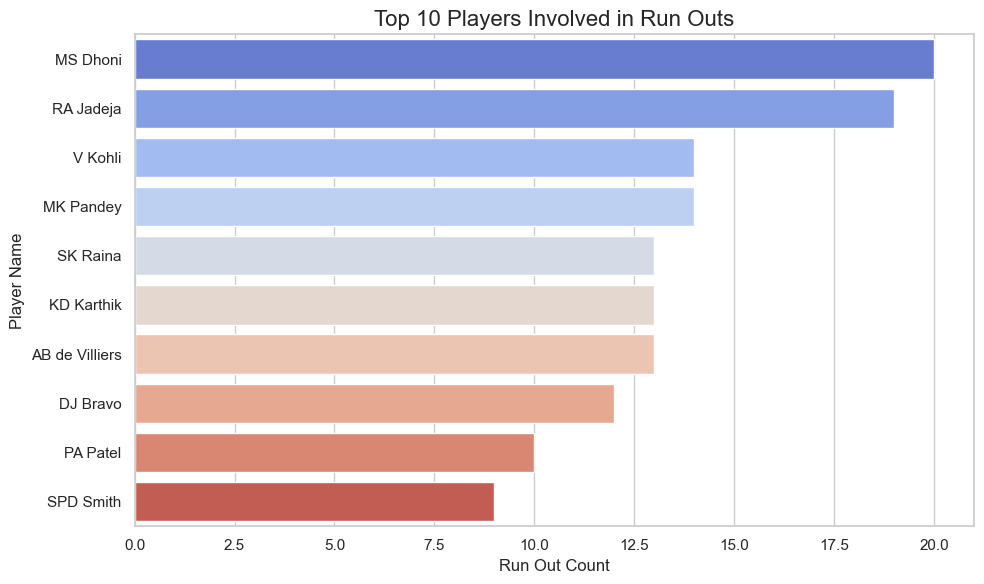

In [35]:
run_outs = ball_by_ball_df.filter(ball_by_ball_df['out_type'] == 'run out') \
                          .groupBy('fielder_sk') \
                          .agg(F.count('out_type').alias('run_out_count')) \
                          .orderBy(F.desc('run_out_count'))

run_outs_with_names = run_outs.join(player_df, run_outs['fielder_sk'] == player_df['player_sk'], 'inner') \
                                .select(player_df['player_name'], run_outs['run_out_count'])

top_run_outs_with_names = run_outs_with_names.orderBy(F.desc('run_out_count')).limit(10)

top_run_outs_pd = top_run_outs_with_names.toPandas()

player_names = top_run_outs_pd['player_name']
run_out_counts = top_run_outs_pd['run_out_count']

plt.figure(figsize=(10, 6))
sns.barplot(x=run_out_counts, y=player_names, palette='coolwarm')

plt.title('Top 10 Players Involved in Run Outs', fontsize=16)
plt.xlabel('Run Out Count', fontsize=12)
plt.ylabel('Player Name', fontsize=12)

plt.tight_layout()
plt.show()

## 6.2. Total Extras per Match and Season


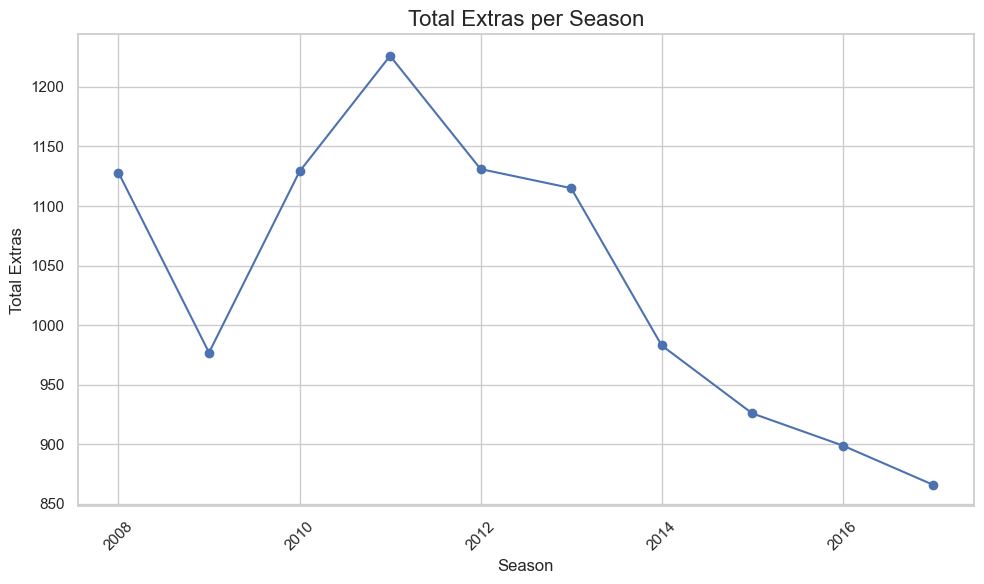

In [36]:
extras = ball_by_ball_df.withColumn('total_extras', F.col('wides') + F.col('noballs') + F.col('byes') + F.col('legbyes') + F.col('penalty'))
season_extras = extras.groupBy('season').agg(F.sum('total_extras').alias('total_extras')).orderBy(F.asc('season'))

season_extras_pd = season_extras.toPandas()

seasons = season_extras_pd['season']
total_extras = season_extras_pd['total_extras']

plt.figure(figsize=(10, 6)) 
plt.plot(seasons, total_extras, marker='o', linestyle='-', color='b')

plt.title('Total Extras per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Extras', fontsize=12)

plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()

# 7. Key Factors for Player Selection

## 7.1. Player Batting Performance
### Factor: Runs scored, Strike Rate, and Consistency
  ***Rating=0.5×avg_runs_per_match+0.3×strike_rate+0.2×total_runs***
### Key Metric: Total runs scored, average runs per match, and strike rate.
### Insight: Top-performing batsmen with consistent runs across matches and seasons should be prioritized. Players who have a high strike rate, especially in key overs (powerplay and death overs), will be more valuable in aggressive game situations.


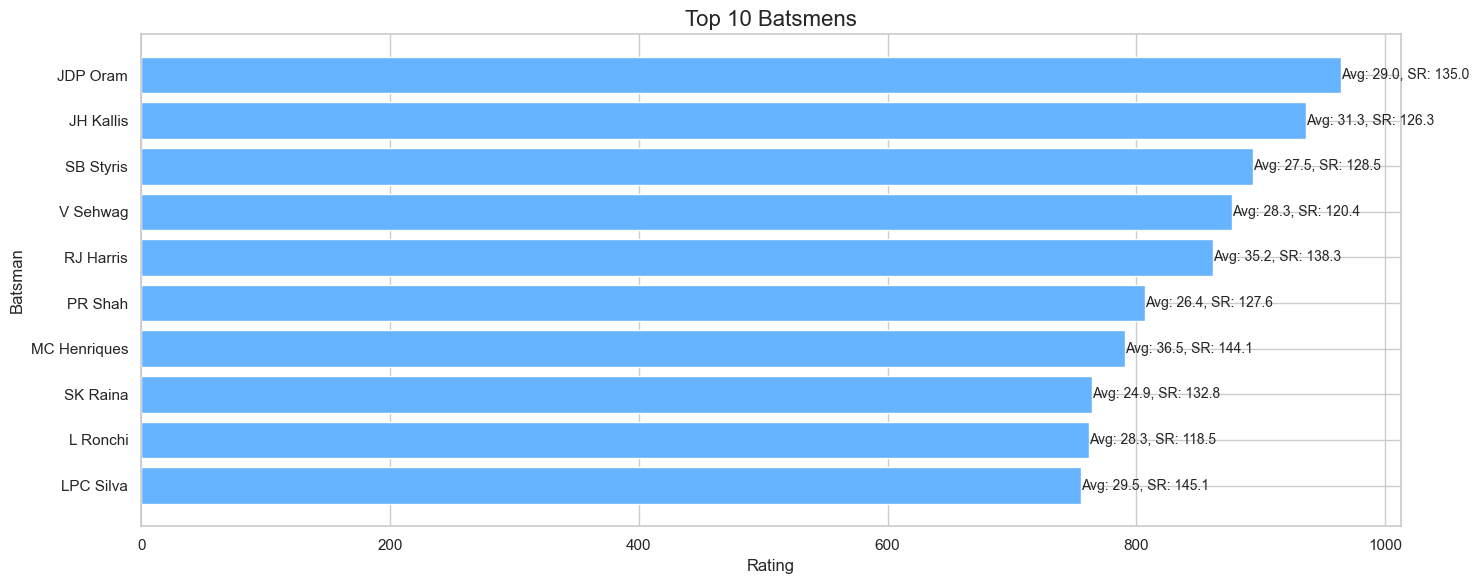

In [37]:
batsman_performance = ball_by_ball_df.groupBy('striker').agg(
    F.sum('runs_scored').alias('total_runs'),
    F.countDistinct('match_id').alias('matches_played'),
    (F.sum('runs_scored') / F.countDistinct('match_id')).alias('avg_runs_per_match'),
    ((F.sum('runs_scored') / F.count('ball_id'))*100).alias('strike_rate')
).orderBy(F.desc('total_runs'))

batsman_performance_with_rating = batsman_performance.withColumn(
    'rating',
    0.5 * F.col('avg_runs_per_match') +
    0.3 * F.col('strike_rate') +
    0.2 * F.col('total_runs')
)

top_batsmen = batsman_performance_with_rating.orderBy(F.desc('rating')).limit(10)

top_batsmen_with_names = top_batsmen.join(player_df, top_batsmen['striker'] == player_df['player_sk'], 'inner') \
                                     .select(player_df['player_name'], top_batsmen['avg_runs_per_match'], top_batsmen['strike_rate'], top_batsmen['rating'])

top_batsmen_pd = top_batsmen_with_names.toPandas()
top_batsmen_pd = top_batsmen_pd.sort_values(by='rating', ascending=True)

player_names = top_batsmen_pd['player_name']
ratings = top_batsmen_pd['rating']
avg_runs = top_batsmen_pd['avg_runs_per_match']
strike_rates = top_batsmen_pd['strike_rate']

plt.figure(figsize=(15, 6))
bars = plt.barh(player_names, ratings, color='#66b3ff')

for bar, avg, sr in zip(bars, avg_runs, strike_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'Avg: {avg:.1f}, SR: {sr:.1f}',
             va='center', ha='left', fontsize=10)

plt.title('Top 10 Batsmens', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Batsman', fontsize=12)

plt.tight_layout()

plt.show()

### Strategy:
Select batsmen with high average runs and strike rate, especially when facing strong bowling line-ups.
Consider left-hand and right-hand combinations based on bowler type (e.g., right-arm off-spinners vs. left-hand batsmen)


## 7.2. Player Bowling Performance
### Factor: Wickets taken, Economy Rate, and Wicket-Taking Ability in Crucial Overs
### Key Metric: Total wickets, average wickets per match, and economy rate.
***Rating = 0.5 × avg_wickets_per_match + 0.3 × (100 - economy_rate) + 0.2 × total_wickets***
### Insight: Bowlers who excel in taking wickets during critical overs (powerplay and death overs) are essential for shifting the game’s momentum. A low economy rate, particularly in the death overs, is crucial for preventing opponents from accelerating their run rate, making such bowlers highly valuable in competitive scenario


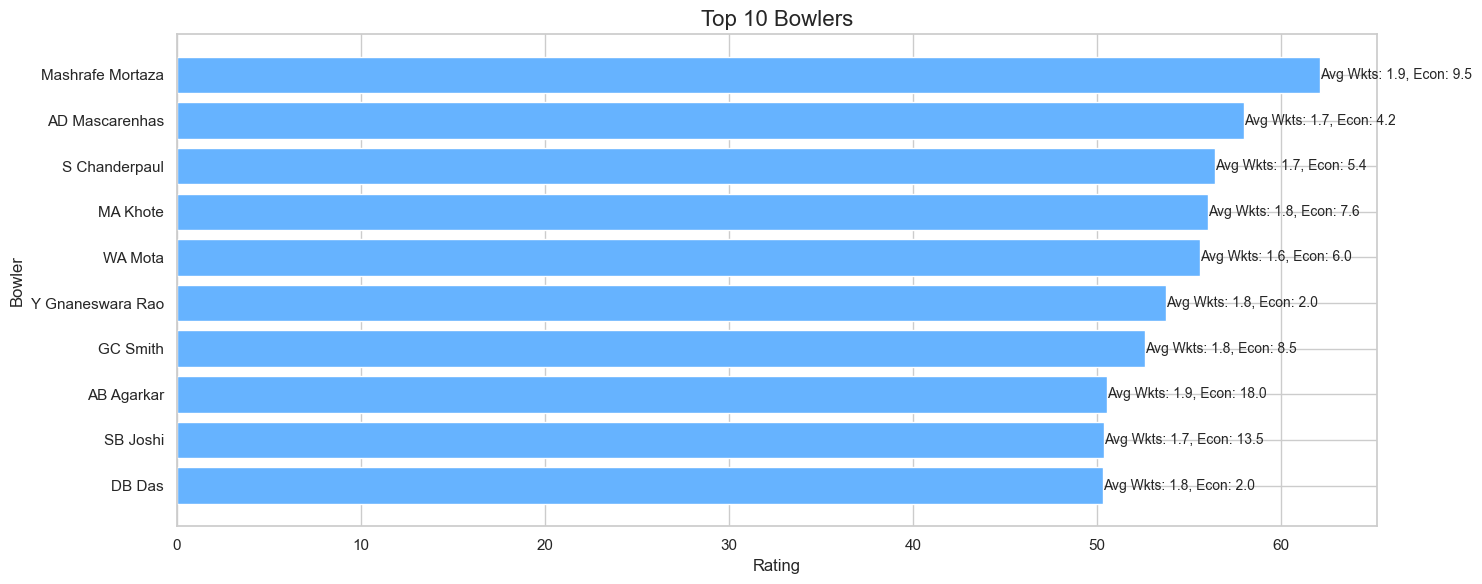

In [38]:
bowler_performance = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    ((F.sum('runs_scored') / (F.countDistinct('over_id') / 6)) * 6).alias('economy_rate')
)

bowler_performance_with_rating = bowler_performance.withColumn(
    'rating',
    0.5 * F.col('avg_wickets_per_match') +
    0.3 * (100 - F.col('economy_rate')) + 
    0.2 * F.col('total_wickets')
)

top_bowlers = bowler_performance_with_rating.orderBy(F.desc('rating')).limit(10)

top_bowlers_with_names = top_bowlers.join(player_df, top_bowlers['bowler'] == player_df['player_sk'], 'inner') \
                                     .select(player_df['player_name'], top_bowlers['avg_wickets_per_match'], top_bowlers['economy_rate'], top_bowlers['rating'])

top_bowlers_pd = top_bowlers_with_names.toPandas()
top_bowlers_pd = top_bowlers_pd.sort_values(by='rating', ascending=True)

player_names = top_bowlers_pd['player_name']
ratings = top_bowlers_pd['rating']
avg_wickets = top_bowlers_pd['avg_wickets_per_match']
economy_rates = top_bowlers_pd['economy_rate']

plt.figure(figsize=(15, 6))
bars = plt.barh(player_names, ratings, color='#66b3ff')

for bar, avg, econ in zip(bars, avg_wickets, economy_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'Avg Wkts: {avg:.1f}, Econ: {econ:.1f}',
             va='center', ha='left', fontsize=10)

plt.title('Top 10 Bowlers', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Bowler', fontsize=12)

plt.tight_layout()
plt.show()

### Strategy:
Select bowlers with high wicket-taking ability in powerplay and death overs.
Focus on economy rate when selecting bowlers for matches with smaller boundaries or high-scoring venues.


## 7.3. Player Fielding and Catching Ability
### Factor: Impact in Run Outs, Catches, and Fielding Positions
### Key Metric: Number of run-outs, catches, and fielding positions.
### Insight: Strong fielders, particularly those who specialize in difficult positions (e.g., inner circle, boundary), can save critical runs and contribute to breaking partnerships through run-outs and catches.

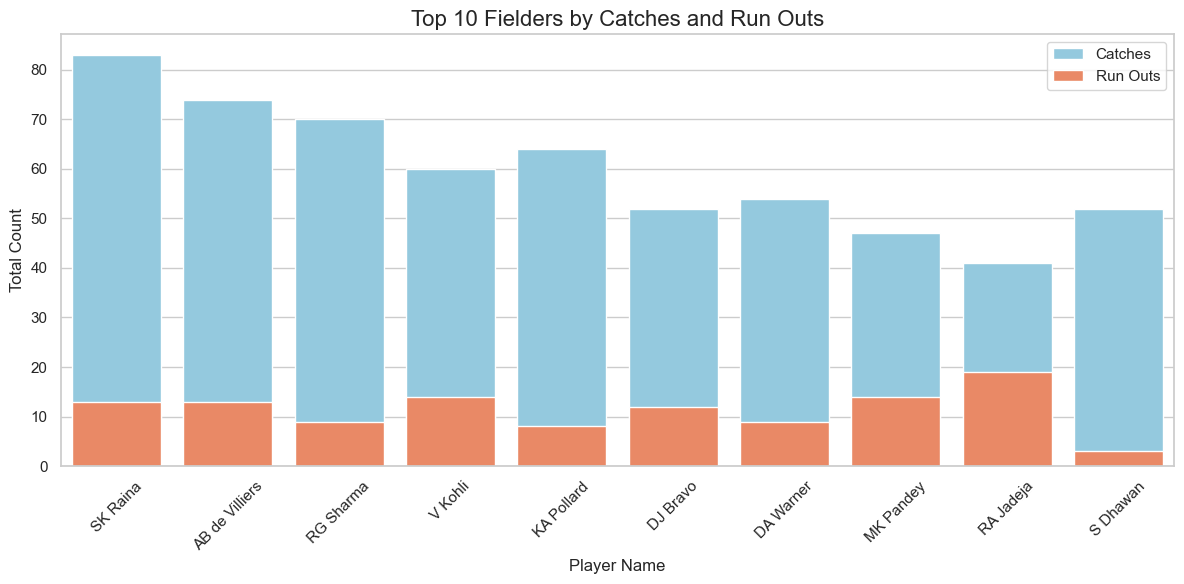

In [39]:
fielder_performance = ball_by_ball_df.filter(
    (ball_by_ball_df['out_type'] == 'caught') | (ball_by_ball_df['out_type'] == 'run out')
).groupBy('fielder_sk').agg(
    F.sum(F.when(ball_by_ball_df['out_type'] == 'caught', 1).otherwise(0)).alias('total_catches'),
    F.sum(F.when(ball_by_ball_df['out_type'] == 'run out', 1).otherwise(0)).alias('total_runouts')
)

fielder_performance_with_names = fielder_performance.join(
    player_df,
    fielder_performance['fielder_sk'] == player_df['player_sk'],
    'inner'
).select(
    player_df['player_name'],
    fielder_performance['total_catches'],
    fielder_performance['total_runouts']
)

top_fielder_performance = fielder_performance_with_names.orderBy(
    (fielder_performance_with_names['total_catches'] + fielder_performance_with_names['total_runouts']).desc()
).limit(10)

top_fielder_performance_pd = top_fielder_performance.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(data=top_fielder_performance_pd,
            x='player_name',
            y='total_catches',
            color='skyblue',
            label='Catches')

sns.barplot(data=top_fielder_performance_pd,
            x='player_name',
            y='total_runouts',
            color='coral',
            label='Run Outs')

plt.title('Top 10 Fielders by Catches and Run Outs', fontsize=16)
plt.xlabel('Player Name', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Strategy:
Prioritize players with strong fielding skills, particularly in high-pressure matches.
Use players with good fielding abilities in the deep or infield for teams with aggressive batsmen.


## 7.4. Player Fitness and Availability
### Factor: Fitness, Recent Form, and Age
### Key Metric: Player’s recent form, age, and fitness records.
### Insight: While player performance is critical, their fitness and availability can affect long-term performance, especially in high-intensity tournaments. Younger players or those with better fitness might be more reliable over long seasons.


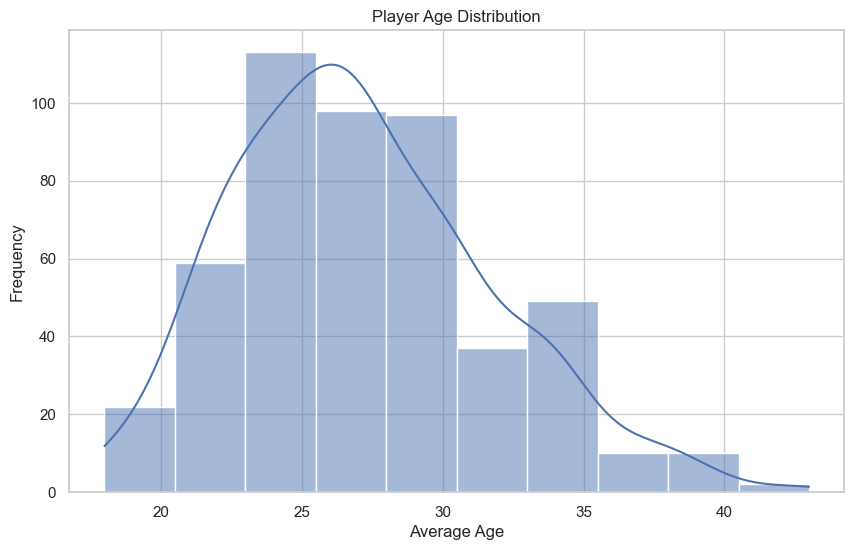

In [40]:
from pyspark.sql.functions import avg, col

player_age_distribution = player_match_df.select("player_name", "age_as_on_match") \
    .na.drop(subset=["age_as_on_match"]) \
    .groupBy("player_name") \
    .agg(avg("age_as_on_match").alias("avg_age")) \
    .withColumn("avg_age", col("avg_age").cast("int")) \
    .orderBy("avg_age")

player_age_distribution_pd = player_age_distribution.toPandas()

plt.figure(figsize=(10, 6))

sns.histplot(data=player_age_distribution_pd, x="avg_age", bins=10, kde=True)

plt.title("Player Age Distribution")
plt.xlabel("Average Age")
plt.ylabel("Frequency")

plt.show()

### Strategy:
Rotate players to prevent injuries and fatigue, ensuring a fresh lineup for critical matches.
Consider younger players or recently performing players who are in form, especially if they have had fewer injuries.
